# Deploying our Pneumonia Detection App

![](https://journals.plos.org/plosone/article/figure/image?size=medium&id=10.1371/journal.pone.0256630.g014)

Now that we have our model trained and set up, we can deploy it as a full scale application to the web! While your site is running, you'll be able to use it on your laptop or computer or share it with friends! We'll be using [Streamlit](https://www.streamlit.io/), a library of website objects and methods that allows us to quickly build a site.

# Streamlit - Deploying your model to the web

The goal of this session is to learn how to deploy the models that we have been training to the web so they can be shared with the world!

Let's start with an example.

Check out [this example](https://deyb12-poem-image-generator-using-openai-api-poem-app-732rmo.streamlit.app/) and/or [this example](https://bgremoval.streamlit.app/) and answer the following
**questions:**
* Who is this application for?
* How does the user input data - are these intuitive ways of interacting with the app?
* What does the application do with the data?
* Evaluate the ease of use and look of the application.

(More cool examples [here](https://streamlit.io/gallery?category=favorites)!)

Today, we'll try to deploy our **pneumonia detection model** to the web.

In [ ]:
#@title Run this to download data and prepare our environment!
# %tensorflow_version 1.x

!pip -q install streamlit > /dev/null
!pip -q install pyngrok > /dev/null

import tensorflow as tf
import pandas as pd
import zipfile
import gdown
import cv2
import plotly.express as px
import numpy as np
from pyngrok import ngrok
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint
import random
import time
import os
from keras.callbacks import ModelCheckpoint

from imgaug import augmenters
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)

def flip_left_right(data, prob):
  fun = augmenters.Fliplr(p = prob)
  return augment(data, fun)

def flip_up_down(data, prob):
  fun = augmenters.Flipud(p = prob)
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    field_data, field_labels = get_data_split('field', flatten, all_data, metadata, image_shape)
    field_data[:,:,:,2] = field_data[:,:,:,0]
    field_data[:,:,:,1] = field_data[:,:,:,0]

    #make data messier
    rand = random.uniform(-1, 1)

    for i in range(len(field_data)):
      image = field_data[i]

      if abs(rand) < 0.5:
        image = rotate(image, rotate = rand * 40)
      elif abs(rand) < 0.8:
        image = shear(image, shear = rand*40)
      field_data[i] = image
    return field_data, field_labels

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.legacy.RMSprop(learning_rate=1e-5, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = False):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    # expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))
    # expert_model.add(Dropout(0.3))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"


### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

def launch_website():
  print ("Click this link to try your web app:")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  public_url = ngrok.connect()
  print (public_url)
  !streamlit run --server.port 80 app.py >/dev/null

metadata.csv.1      100%[===================>]  39.56K  --.-KB/s    in 0s      
image_data.npy.1    100%[===================>] 131.25M   220MB/s    in 0.6s    


<font color=SlateGrey><h2><b>
Use [these](https://drive.google.com/file/d/12zwuOuKh91VSHIHS-6S4ADF4HLC2wKJq/view?usp=sharing) instructions to create a ngrok account and get your authtoken!
</b></h2></font>

<font color=DarkGray><h3><b>
Paste your authtoken below next to `!ngrok authtoken`!
</b></h3></font>

In [ ]:
!ngrok authtoken 2TdcyERyP5WwkVg5gplip4mME5b_4u5WSoJa74MfxPDqyjLyg

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## Step 1: Making a website with streamlit

Streamlit interprets Python files as a website! This is great for several reasons
* No need to know HTML, CSS, Javascript,... etc
* Easy to use our trained models which are already in Python!

We'll write everything to a file called app.py, which is used for Streamlit to launch the site.


In [ ]:
%%writefile app.py
import streamlit as st

st.title("Pneumonia Detection")
st.header("Description of the app")

Overwriting app.py


In [ ]:
from pyngrok import ngrok
#Publish Web App (Run this again whenever you make changes)
launch_website()

Click this link to try your web app:


NgrokTunnel: "https://cefa-35-245-17-35.ngrok-free.app" -> "http://localhost:80"


## Step 2: Loading the model

Since the focus of this session is deployment we'll skip over training the model and just load one that we've already trained :)

Here is a reference on how to save and load sklearn and tensorflow models!

For sklearn:
```
from joblib import dump, load

# ====== Save model ========
dump(model, 'filename.joblib')

# ====== Load model ========
clf = load('filename.joblib')
```

For tensorflow:
```
import tensorflow as tf

# ====== Save model ========
model.save("filename.h5")

# ====== Load model ========
tf.keras.models.load_model("filename.h5")
```

Our model today is going to be a tensorflow model! Let's load in the model we created last time:




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

cnn_path = F"/content/gdrive/My Drive/cnn.zip"

with zipfile.ZipFile(cnn_path, 'r') as zip_ref:
    zip_ref.extractall('')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We can set it to model and double check its shape.

In [ ]:
# Load your model
model = tf.keras.models.load_model("cnn")

In [ ]:
# Take a look at the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_29 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_30 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

## Step 3: Accept file uploads

We want to allow the user of the website to upload their own images to our website for our model to make predictions on. This can be accomplished by the following line:

`f = st.file_uploader("Upload Image")`

We can then extract and display with the following lines of code

```
if f is not None:
  file_bytes = np.asarray(bytearray(f.read()), dtype=np.uint8)
  image = cv2.imdecode(file_bytes, 1)
  st.image(image, channels="BGR")
```

Exercise: Add this code to app.py, run the website and try it out!

Hint: Dont forget to

`import numpy as np`

and

`import cv2`

at the top of the file.

In [ ]:
%%writefile app.py
import streamlit as st
import zipfile
import base64
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

# Extract the CNN model from the zip file
cnn_path = "/content/gdrive/My Drive/cnn.zip"
with zipfile.ZipFile(cnn_path, 'r') as zip_ref:
    zip_ref.extractall('')

# Load the CNN model
cnn =tf.keras.models.load_model("cnn")

# Create a Title
st.title("Pneumonia Detection")
st.header("Description of the app")

# Function to process the uploaded image into a format that the model can use
def process_image(image):
    # Convert the image to RGB mode
    image = image.convert('RGB')

    # Resize the image
    image = image.resize((64, 64))

    # Convert the image to an array and normalize
    img_array = np.array(image).astype('float32')
    img_array = img_array / 255.0

    # Expand dimensions to match the expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Display the image upload widget using st.file_uploader
f = st.file_uploader("Upload Image")

# Perform prediction and display the result
if f is not None:
    # Read the uploaded image
    image = Image.open(f)

    # Process and classify the image
    processed_image = process_image(image)
    prediction = cnn.predict(processed_image)
    diagnoses = (prediction > 0.5).astype(int)
    pred_diagnosis = "Pneumonia" if diagnoses else "No Pneumonia"

    # Display the processed image
    st.image(image)

    # Display the predicted diagnosis
    st.header("Prediction")
    st.subheader("Diagnosis")
    st.write(pred_diagnosis)


Overwriting app.py


While running your site, you can try fetching some images from our original dataset below. You can download the image by right-clicking the generated image and `Save image as...` before uploading it to your site!

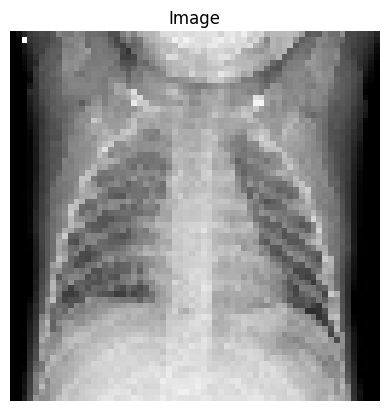

Label: No Pneumonia


In [ ]:
#@title Fetch Image { run: "auto", vertical-output: true, display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image data
image_data = np.load('image_data.npy')

# Load the metadata
metadata = pkg.get_metadata(metadata_path, ['train', 'test'])

# Choose an index to download the corresponding image
input_index = "12" #@param {type:"string"}
index = int(input_index)

# Get the image from the data array
image = image_data[index]

# Remove the extra channel if it exists
if image.shape[-1] == 4:
    image = image[:, :, :3]

# Create a PIL image object
pil_image = Image.fromarray(np.uint8(image))

# Get the label for the image using the metadata
label = metadata.iloc[index]['class']  # Replace 'class' with the appropriate column name in your metadata
if label == 0:
    label = 'No Pneumonia'
else:
    label = 'Pneumonia'

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title('Image')
plt.show()

# Print the label to the terminal
print(f'Label: {label}')

In [ ]:
from pyngrok import ngrok
#Publish Web App (Run this again whenever you make changes)
launch_website()

Click this link to try your web app:


NgrokTunnel: "https://3ea8-35-245-17-35.ngrok-free.app" -> "http://localhost:80"
2023-08-07 03:12:54.227953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### (Optional, if time permits) Spend some time thinking about better ways to visualize and use the model, and update app.py

In [ ]:
%%writefile app.py
import streamlit as st
import zipfile
import base64
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

# Extract the CNN model from the zip file
cnn_path = "/content/gdrive/My Drive/cnn.zip"
with zipfile.ZipFile(cnn_path, 'r') as zip_ref:
    zip_ref.extractall('')

# Load the CNN model
cnn = # YOUR CODE HERE

# Create a Title
# YOUR CODE HERE

# Function to process the uploaded image into a format that the model can use
def process_image(image):
    # Convert the image to RGB mode
    image = image.convert('RGB')

    # Resize the image
    image = image.resize((64, 64))

    # Convert the image to an array and normalize
    img_array = np.array(image).astype('float32')
    img_array = img_array / 255.0

    # Expand dimensions to match the expected input shape
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Display the image upload widget using st.file_uploader
# YOUR CODE HERE

# Perform prediction and display the result
if uploaded_file is not None:
    # Read the uploaded image
    image = Image.open(YOUR CODE HERE)

    # Process and classify the image
    processed_image = YOUR CODE HERE
    prediction = YOUR CODE HERE
    diagnoses = YOUR CODE HERE
    pred_diagnosis = YOUR CODE HERE

    # Display the processed image
    YOUR CODE HERE

    # Display the predicted diagnosis
    st.header("Prediction")
    st.subheader("Diagnosis")
    st.write(pred_diagnosis)
